<a href="https://colab.research.google.com/github/tsor13/OthelloRL/blob/master/Othello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# IMPORTS
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
from tqdm import tqdm
import pdb
from matplotlib import pyplot as plt
from torch.nn import functional as F
from math import sqrt, exp
import time
import os

In [0]:
# connect to drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/OthelloData/'

loss:9.094: 100%|██████████| 3920/3920 [03:16<00:00, 19.09it/s]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# PARAMS
device = 'cuda'

In [0]:
# othello.py
def hash_board(s):
    return hash(str(s))

def start_board():
    # 0 for unused, 1 for black, 2 for white
    board = np.zeros((8, 8), dtype=np.int64)
    # initial layout
    board[3,3] = 1
    board[3,4] = 2
    board[4,3] = 2
    board[4,4] = 1
    # black starts
    turn = 1
    return board, turn

def tiles_to_flip(board, turn, x, y):
    ''' Return a list of tiles that would be flipped if given piece was placed at location'''
    tiles = [(x, y)]

    if board[x,y] != 0:
        return tiles

    def in_bounds(i, j):
        return not (i < 0 or j < 0 or i >= 8 or j >= 8)

    # define search directions
    directions = [[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]]
    # look in each direction
    for x_d, y_d in directions:
        potentials = []
        i, j = x, y
        done = False
        while not done:
            i, j = i+x_d, j+y_d
            # if out of bounds, never hits own piece
            if not in_bounds(i, j):
                done = True
            # if hits empty slot, return
            elif board[i, j] == 0:
                done = True
            # if we hit current piece, extend
            elif board[i, j] == turn:
                tiles.extend(potentials)
                done = True
            # else, opponents piece and it can potentially be flipped
            else:
                potentials.append((i, j))
    return tiles

def legal_moves(board, turn):
    moves = []
    # if game end
    if turn <= 0:
        return moves
    for i in range(8):
        for j in range(8):
            # if it would flip tiles over, then legal
            if len(tiles_to_flip(board, turn, i, j)) != 1:
                moves.append((i,j))
    return moves

def flip_turn(turn):
    if turn == 1:
        return 2
    elif turn == 2:
        return 1

def move(board, turn, i, j):
    flip = tiles_to_flip(board, turn, i, j)
    assert len(flip) != 1, 'Illegal move'
    board = deepcopy(board)
    # flip tiles
    for r, c in flip:
        board[r, c] = turn

    turn = flip_turn(turn)
    # if no legal moves, flip
    if len(legal_moves(board, turn)) == 0:
        turn = flip_turn(turn)
        # if still no legal moves, end game
        if len(legal_moves(board, turn)) == 0:
            turn = 0
    return board, turn

def make_current_black(board, turn):
    if turn == 2:
        board = deepcopy(board)
        board[board == 1], board[board == 2] = -2, -1
        board[board == -1], board[board == -2] = 1, 2
        turn = 1
    return board, turn

def get_reward(board, player):
    # assert (board == 0).sum() == 0, 'Reward called when game not done'
    player_count = (board == player).sum()
    opponent = 1 if player == 2 else 2
    opponent_count = (board == opponent).sum()
    if player_count > opponent_count:
        return 1
    elif player_count < opponent_count:
        return -1
    else:
        return 0

def get_rewards(board):
    black = (board == 1).sum()
    white = (board == 2).sum()
    if black > white:
        return 1, 0
    elif black < white:
        return 0, 1
    elif black == white:
        return .5, .5

In [0]:
# helper.py
def tensor_from_board(board, actions):
    board = torch.Tensor(board).to(device).unsqueeze(0)
    W, B, A = (board == 1).float(), (board == 2).float(), torch.zeros(board.shape)
    W, B, A = W.to(device), B.to(device), A.to(device)
    x =  torch.cat([W, B, A])
    x = x.float()
    for i, j in actions:
        x[2,i,j] = 1
    return x

def get_objectives(nodes, boards, actions, min_count):
    # policy = normalized counts
    # value = mean value
    X, P, V = [], [], []
    for key, board in boards.items():
        total_n = 0
        total_value = 0
        if key in actions:
            for a in actions[key]:
                N, W, _, _ = nodes[key, a]
                total_n += N
                total_value += W
            v = total_value / total_n
            p = np.zeros(board.shape)
            for a in actions[key]:
                N, _, _, _ = nodes[key, a]
                i, j = a
                p[i,j] = N / total_n
            # get tensor
            x = tensor_from_board(board, actions[key])
            x = x.cpu().detach().numpy()
            # add to arrays
            if total_n > min_count:
                X.append(x)
                V.append(v)
                P.append(p)
    return X, P, V

def augment(X, P, V):
    # horizontal flip, vertical flip, transpose
    # these can all be transposed with eachother
    X_, V_, P_ = [], [], []
    def horizontal_flip(x, v, p):
        return x[:,::-1], v, p[::-1]
    def vertical_flip(x, v, p):
        return x[:,:,::-1], v, p[:,::-1]
    def transpose(x, v, p):
        # TODO correct?
        return np.transpose(x, (0,2,1)), v, p.T
    def add(x, v, p):
        X_.append(x)
        V_.append(v)
        P_.append(p)
    for obs in zip(X, V, P):
        add(*horizontal_flip(*obs))
        add(*vertical_flip(*obs))
        add(*transpose(*obs))
        add(*obs)
    return X_, P_, V_

In [0]:
# OthelloZero.py
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = channels,
                               out_channels = channels,
                               kernel_size = 3,
                               padding = 1)
        self.relu1 = nn.ReLU()
        # TODO right here?
        self.batchnorm1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(in_channels = channels,
                               out_channels = channels,
                               kernel_size = 3,
                               padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        d = self.conv1(x)
        d = self.batchnorm1(d)
        d = self.relu1(d)
        d = self.conv2(d)
        d = self.batchnorm2(d)
        # skip connection
        x = x + d
        x = self.relu2(x)
        return x

class PolicyHead(nn.Module):
    def __init__(self, in_channels):
        super(PolicyHead, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_channels,
                              out_channels = 2,
                              kernel_size = 1)
        self.batchnorm = nn.BatchNorm2d(2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8*8*2, 8*8)

        # initialize linear layer to almost zeros, all policies equal initially
        epsilon = 1e-3
        nn.init.uniform_(self.fc.weight, -epsilon, epsilon)
        nn.init.uniform_(self.fc.bias, -epsilon, epsilon)
        # nn.init.zeros_(self.fc.weight)
        # nn.init.zeros_(self.fc.bias)

    def forward(self, x, possible):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = x.reshape(-1, 8*8*2)
        x = self.fc(x)
        x = x.reshape(-1, 8*8)
        # exp
        x = torch.exp(x)
        # restrict to possible moves
        x = x.reshape(-1, 8, 8)
        # mask so only possible moves
        x = x * possible
        # softmax so true probabilities
        x = x / x.sum()
        return x

class ValueHead(nn.Module):
    def __init__(self, in_channels, hidden_size=64):
        super(ValueHead, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_channels,
                              out_channels = 1,
                              kernel_size = 1)
        self.batchnorm = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU()
        self.fcc1 = nn.Linear(8*8, hidden_size)
        self.relu2 = nn.ReLU()
        self.fcc2 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu1(x)
        x = x.reshape(-1, 64)
        x = self.fcc1(x)
        x = self.relu2(x)
        x = self.fcc2(x)
        x = self.tanh(x)
        return x

class OthelloZero(nn.Module):
    def __init__(self, res_layers = 40, channels = 500, in_channels = 2, hidden_size = 64):
        super(OthelloZero, self).__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = channels,
                      kernel_size = 3,
                      padding = 1),
            # nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.res_blocks = nn.ModuleList([ResBlock(channels) for i in range(res_layers)])
        self.policy_head = PolicyHead(channels)
        self.value_head = ValueHead(channels, hidden_size)

    def forward(self, x, turn = 1):
        # split board and possible actions
        x, possible = x[:,:2], x[:,2]

        # switch turn so current is black
        # TODO - works?
        if turn == 2:
            black, white = deepcopy(x[:,0]), deepcopy(x[:,1])
            x[:,0], x[:,1] = white, black

        x = self.convlayer(x)
        for block in self.res_blocks:
            x = block(x)
        p = self.policy_head(x, possible)
        v = self.value_head(x)
        return p, v

In [0]:
# arena.py
def compete(model1, model2, games):
    model1.eval()
    model2.eval()
    wins1, wins2 = 0, 0
    player1, player2 = 1, 2
    loop = tqdm(total = games, position=0, leave=False)
    for game in range(games):
        board, turn = start_board()
        # until game end
        while turn != 0:
            # x = tensor_from_board(board, legal_moves(board, turn))
            # x = x.unsqueeze(0)
            # if turn == player1:
            #     p, v = model1(x, player1)
            # elif turn == player2:
            #     p, v = model2(x, player2)
            # # change later to do tree search, for now just do by prob
            # p = p.cpu().detach().numpy()
            # p = p.reshape(-1)
            # choice = np.random.choice(64, 1, p=p)[0]
            # # TODO - probably wrong
            # i, j = choice // 8, choice % 8
            if turn == player1:
                i, j = MCTS_action(model1, (board, player1))
            elif turn == player2:
                i, j = MCTS_action(model2, (board, player2))
            board, turn = move(board, turn, i, j)

        black_reward, white_reward = get_rewards(board)
        if player1 == 1 and player2 == 2:
            wins1 += black_reward
            wins2 += white_reward
        elif player1 == 2 and player2 == 1:
            wins1 += white_reward
            wins2 += black_reward
        # every other game, switch starting player
        player1, player2 = player2, player1
        loop.update(1)
        loop.set_description('perc:{:.3f}'.format(wins1/(wins1+wins2)))

    return wins1/(wins1+wins2)

# if __name__ == '__main__':
#     model1 = OthelloZero(res_layers=4, channels=10)
#     model2 = OthelloZero(res_layers=4, channels=10)
#     model1, model2 = model1.to(device), model2.to(device)
#     perc = compete(model1, model1, games=100)
#     print(perc)

In [0]:
# MCTS.py

def MCTS(model, iterations = 10, max_time = float('inf'), C = 1, initial = start_board(), show_progress = True):
    # don't keep track of gradients yet
    model.eval()

    def value_function(Q, P, total_N, N):
        return Q + C * P * sqrt((total_N+1)/(N+1))
        # sigmoid = lambda x: exp(x) / (1+exp(x))
        # return p * sigmoid(total_N/(N+1))

    # N, W, Q, P
    # key: str(move_history), action (tuple)
    nodes = {}
    # boards (for backprop)
    # key: str(move_history)
    boards = {}
    # actions
    # key: str(move_history)
    actions = {}

    # start off with no move hist
    move_history = []
    board, turn = initial

    boards[str(move_history)] = board

    # start time
    start_time = time.time()

    if show_progress:
        loop = tqdm(total = iterations, position=0, leave=False)
    for i in range(iterations):
        move_history = []
        board, turn = initial
        # keep track of whose turn it was
        turns = []
        # while game not done
        while turn != 0:
            # populate actions if unexplored yet
            if not actions.get(str(move_history), []):
                actions[str(move_history)] = legal_moves(board, 1)
                x = tensor_from_board(board, actions[str(move_history)])
                x = x.unsqueeze(0)
                p, v = model(x)
                for a in actions[str(move_history)]:
                    i, j = a
                    # default: N = .5 (put a little weight on each possibility)
                    #          W = 0 (total reward is equal to 0 to start)
                    #          Q = 0 (expected reward is equal to 0 to start)
                    #          P = calculated probability from network to start
                    nodes[str(move_history),a] = [.5, 0, 0, p[0, i, j].item()]

            # get total
            total_N = 0
            for a in actions[str(move_history)]:
                N, W, Q, P = nodes[str(move_history), a]
                total_N += N

            # find next action to explore
            max_val, max_action = -1, None
            for a in actions[str(move_history)]:
                N, W, Q, P = nodes[str(move_history), a]
                # choose nodes with high Q or high P/low N
                val = value_function(Q, P, total_N, N)
                if val > max_val:
                    max_val = val
                    max_action = a

            # take move
            board, turn = move(board, 1, max_action[0], max_action[1])
            move_history.append(max_action)

            if turn != 0:
                turns.append(turn)
            board, turn = make_current_black(board, turn)
            boards[str(move_history)] = board

        # remove last turn (end)
        try:
            turns.pop()
        except:
            pass
        # get reward with respect to last player
        v = get_reward(board, 1)
        while move_history:
            a = move_history.pop()
            # N += 1
            nodes[str(move_history), a][0] += 1
            # W += v
            nodes[str(move_history), a][1] += v
            # Q = (N+W) / 2 / N
            N, W, _, _ = nodes[str(move_history), a]
            nodes[str(move_history), a][2] = (N+W) / 2 / N
            # if turn changes, the reward changes
            try:
                t = turns.pop()
                if t == 2:
                    v *= -1
            except:
                v *= -1
                pass
        if show_progress:
            loop.update(1)
        if time.time() - start_time > max_time:
            break

    return nodes, boards, actions

def MCTS_action(model, initial, iterations = 500, max_time = .5, C = 1, temp = .1):
    if initial[1] == 2:
        initial = make_current_black(*initial)
    nodes, boards, actions = MCTS(model, iterations, max_time, C, initial, show_progress = False)
    # randomly select node with more explorations more often?
    A = actions['[]']
    p = np.zeros(len(A))
    # populate counts
    for i, a in enumerate(A):
        p[i] = nodes['[]',a][0]
    p = p ** (1/temp)
    p *= 1/p.sum()
    index = np.random.choice(len(A), 1, p=p)[0]
    return A[index]

# if __name__ == '__main__':
#     model = OthelloZero(res_layers=4, channels=10)
#     model.to(device)
#     print('start')
#     nodes, boards, actions = MCTS(model, 1000)
#     X, P, V = get_objectives(nodes, boards, actions)
#     pdb.set_trace()
#     # pdb.set_trace()
#     print(P[0])
#     print(V[0])
#     X, P, V = augment(X, P, V)
#     print('end')

In [0]:
# RolloutDataset.py

class RolloutDataset(Dataset):
    def __init__(self, X, P, V):
        super(RolloutDataset, self).__init__()
        assert len(X) == len(P) and len(P) == len(V), 'Rollouts of different size'
        self.X, self.P, self.V = X, P, V

    def __getitem__(self, index):
        return self.X[index], self.P[index], self.V[index]

    def __len__(self):
        return len(self.X)

In [0]:
# PolicyValueLoss.py

class PolicyValueLoss(nn.Module):
    def __init__(self):
        super(PolicyValueLoss, self).__init__()

    def forward(self, p_hat, v_hat, p, v):
        value_loss = ((v_hat - v)**2).sum()
        # torch.bmm dot product? hopefully
        p = p.reshape(-1, 64)
        p_hat = p.reshape(-1, 64)
        total_loss = value_loss
        for b, i in torch.nonzero(p_hat):
            total_loss += -p[b,i] * torch.log(p_hat[b,i])
        # policy_loss = -torch.bmm(p * torch.log(p_hat)).sum()
        # return value_loss + policy_loss
        return total_loss

In [0]:
# train.py

def train(params={}):
    model = params.get('model', OthelloZero(res_layers=4, channels=10).to(device))
    model_path = params.get('model path', os.path.join(root_path, 'model.pth'))
    iterations = params.get('iterations', 500)
    max_time = params.get('max time', float('inf'))
    min_count = params.get('min count', 10)
    num_tree_searches = params.get('num tree searches', 10)

    batch_size = params.get('batch size', 8)
    epochs = params.get('epochs', 10)

    loss_function = params.get('loss function', PolicyValueLoss())
    learning_rate = params.get('learning rate', 3e-4)

    eval_every = params.get('eval every', 5)

    compete_games = params.get('compete games', 400)

    model1 = deepcopy(model)
    for i in range(num_tree_searches):
        # do tree search
        nodes, boards, actions = MCTS(model,
                                      iterations = iterations,
                                      max_time = max_time)
        # convert to goals
        X, P, V = get_objectives(nodes, boards, actions, min_count = min_count)
        # augment
        # X, P, V = augment(X, P, V)

        # training loaders
        train_dataset = RolloutDataset(X, P, V)
        train_loader = DataLoader(train_dataset,
                                  batch_size = batch_size,
                                  shuffle = True,
                                  num_workers = 0)

        # optimizer
        optimizer = optim.Adam(model.parameters(), learning_rate)

        # training loop
        loop = tqdm(total = len(train_loader)*epochs, position=0, leave=False)
        model.train()
        losses = []

        for epoch in range(epochs):
            for batch, (x, p, v) in enumerate(train_loader):
                x, p, v = x.to(device), p.to(device), v.to(device)

                optimizer.zero_grad()

                p_hat, v_hat = model(x)
                p_hat, v_hat = p_hat.double(), v_hat.double()

                loss = loss_function(p_hat, v_hat, p, v)
                loss.backward()
                losses.append(loss.item())

                optimizer.step()

                loop.update(1)
                loop.set_description('loss:{:.3f}'.format(loss.item()))
        plt.plot(losses)
        plt.show()
        print('Mean Loss: {:.3f}'.format(sum(losses)/len(losses))) 
        # TODO - save only when improves?
        # save at end of every tree search (for now)
        torch.save(model.state_dict(), model_path)
        print('Saved model')
        if (i+1)%eval_every == 0:
            perc_win = compete(model, model1, compete_games)
            print(f'After train: {perc_win}')
    return model


In [0]:
model_path = os.path.join(root_path, 'model.pth')
params = {
    'model': OthelloZero(res_layers=5, channels=16).to(device),
    'model path': model_path,
    'iterations': 1000,
    'epochs': 20,
    'num tree searches': 100,
    'min count': 10,
    'learning rate': 3e-4,
    'eval every': 20,
    'compete games': 200,
}
model = train(params)

  0%|          | 0/2260 [00:00<?, ?it/s]

> <ipython-input-29-18d091367f23>(61)train()
-> p_hat, v_hat = p_hat.double(), v_hat.double()
(Pdb) c


loss:28.817:   0%|          | 1/2260 [00:04<2:48:18,  4.47s/it]

> <ipython-input-29-18d091367f23>(60)train()
-> pdb.set_trace()
(Pdb) q


BdbQuit: ignored

  0%|          | 0/1000 [00:00<?, ?it/s]



	MODEL 1 



loss:6.018: 100%|██████████| 2520/2520 [01:54<00:00, 22.94it/s]

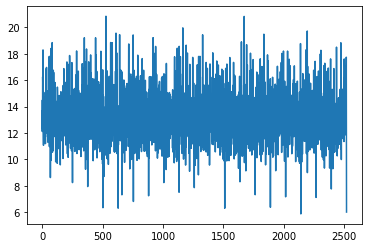

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 13.176
Saved model


loss:15.695: 100%|██████████| 2940/2940 [02:25<00:00, 20.20it/s]

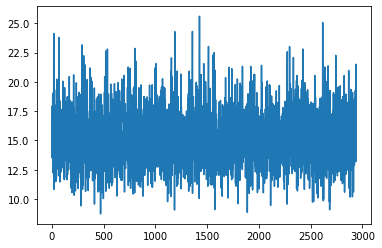

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 15.185
Saved model


loss:11.782: 100%|██████████| 3240/3240 [02:37<00:00, 20.09it/s]

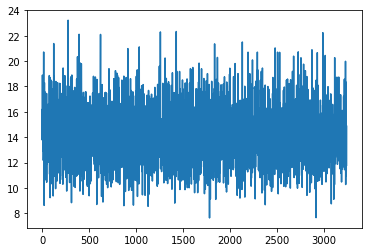

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 14.156
Saved model


loss:6.839: 100%|██████████| 3520/3520 [02:57<00:00, 21.26it/s] 

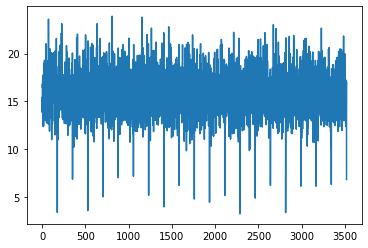

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 15.840
Saved model


loss:4.615: 100%|██████████| 3280/3280 [02:41<00:00, 20.63it/s] 

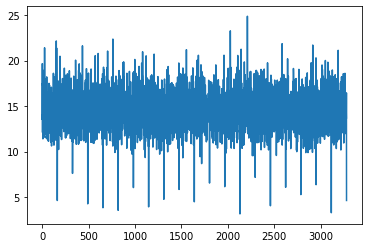

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 14.451
Saved model


loss:2.951: 100%|██████████| 2700/2700 [02:12<00:00, 20.52it/s] 

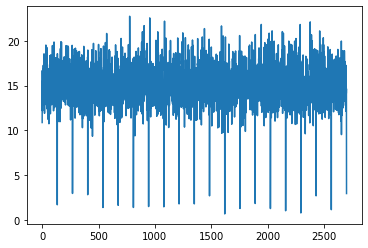

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 15.092
Saved model


loss:5.545: 100%|██████████| 2740/2740 [02:12<00:00, 19.88it/s] 

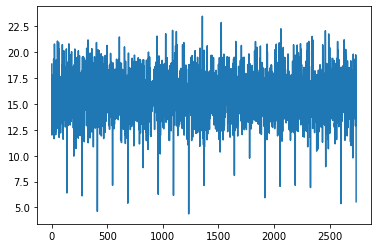

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 15.779
Saved model


loss:6.420: 100%|██████████| 3180/3180 [02:38<00:00, 19.26it/s] 

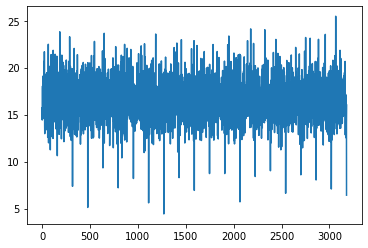

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 16.637
Saved model


loss:5.486: 100%|██████████| 3520/3520 [03:03<00:00, 19.45it/s] 

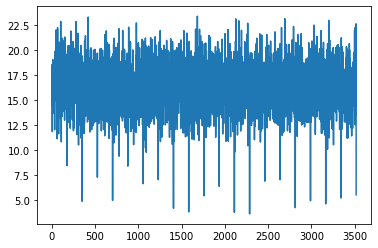

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean Loss: 16.267
Saved model


loss:2.318: 100%|██████████| 4160/4160 [03:29<00:00, 23.75it/s] 

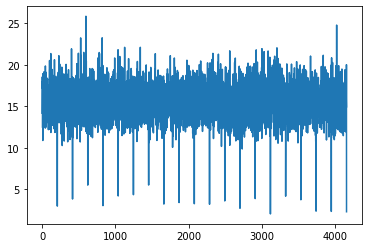

  0%|          | 0/200 [00:00<?, ?it/s]

Mean Loss: 15.515
Saved model


perc:0.531:  49%|████▉     | 98/200 [54:07<56:35, 33.29s/it]

In [0]:
from copy import deepcopy
# hyperparam search
params1 = {
    'model': OthelloZero(res_layers=5, channels=16).to(device),
    'model path': os.path.join(root_path, 'model1.pth'),
    'iterations': 1000,
    'epochs': 20,
    'num tree searches': 10,
    'min count': 10,
    'learning rate': 3e-4,
    'eval every': 10,
    'compete games': 200,
}

params2 = deepcopy(params1)
params2['min count'] = 5
params2['model path'] = os.path.join(root_path, 'model2.pth')

params3 = deepcopy(params1)
params3['iterations'] = 1500
params3['model path'] = os.path.join(root_path, 'model3.pth')

print('\n\n\tMODEL 1 \n')
model1 = train(params1)
print('\n\n\tMODEL 2 \n')
model2 = train(params2)
print('\n\n\tMODEL 3 \n')
model3 = train(params3)

{'epochs': 20,
 'eval every': 10,
 'iterations': 2000,
 'learning rate': 0.0003,
 'min count': 10,
 'model': OthelloZero(
   (convlayer): Sequential(
     (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
   )
   (res_blocks): ModuleList(
     (0): ResBlock(
       (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu1): ReLU()
       (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu2): ReLU()
     )
     (1): ResBlock(
       (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu1): ReLU()
       (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(

  0%|          | 0/10 [00:00<?, ?it/s]

> <ipython-input-29-18d091367f23>(61)train()
-> p_hat, v_hat = p_hat.double(), v_hat.double()
(Pdb) same(model, model3, x)
True
(Pdb) q


BdbQuit: ignored